BU KODU GÖZDEN GEÇİR Bİ ELLE VE BÖLÜMLERE AYIR FALAN FİLAN

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping


In [5]:


# Veri setini yükleyelim
data = pd.read_csv("world_economic_indicators.csv")

print(data.head(5))
print(data.info())

                  Country Name Country Code  Year  \
0                        Aruba          ABW  1960   
1  Africa Eastern and Southern          AFE  1960   
2                  Afghanistan          AFG  1960   
3   Africa Western and Central          AFW  1960   
4                       Angola          AGO  1960   

   Personal remittances, received (% of GDP)  \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                                        NaN   
4                                        NaN   

   Unemployment, total (% of total labor force)  GDP (current US$)_x  \
0                                           NaN                  NaN   
1                                           NaN         2.112502e+10   
2                                           NaN         5.377778e+08   
3                                           NaN         1.044764e+10   
4                               

In [ ]:
# Veriyi temizleyelim ve sadece gerekli sütunları alalım
data_cleaned = data[['Country Name', 'Year', 
                     'Unemployment, total (% of total labor force)', 
                     'GDP (current US$)_x', 'GDP growth (annual %)_x']]

# Almanya verisini filtreleyelim
germany_data = data_cleaned[data_cleaned['Country Name'] == 'Germany']

# Almanya'nın GSYİH büyüme verisini alalım ve eksik değerleri dolduralım
germany_data_filled = germany_data[['Year', 'GDP growth (annual %)_x']].ffill().dropna()

# Yılı index olarak alalım
germany_data_filled.set_index('Year', inplace=True)

# GSYİH büyüme oranını seçelim
gdp_growth = germany_data_filled['GDP growth (annual %)_x'].values

In [7]:
# Veriyi normalize edelim
scaler = MinMaxScaler(feature_range=(0, 1))
gdp_growth_scaled = scaler.fit_transform(gdp_growth.reshape(-1, 1))

# Veriyi eğitim ve test için bölelim
train_size = int(len(gdp_growth_scaled) * 0.8)
train_data = gdp_growth_scaled[:train_size]
test_data = gdp_growth_scaled[train_size:]

In [8]:


# Veriyi X ve y olarak ayıralım (LSTM için geçmiş 5 yıl kullanacağız)
def create_dataset(data, time_step=5):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 5

# Eğitim verisini oluşturma
X_train, y_train = create_dataset(train_data, time_step)

# Test verisini oluşturma
X_test, y_test = create_dataset(test_data, time_step)

# LSTM için input şekli (örnekler, zaman adımları, özellikler)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
# LSTM Modeli Kurma
model = Sequential()

# LSTM katmanları ekleyelim
model.add(LSTM(units=150, return_sequences=True))  # İlk katman, artırılmış nöron sayısı
model.add(Dropout(0.15))  # Dropout oranını düşürdük
model.add(LSTM(units=100, return_sequences=True))  # İkinci katman
model.add(Dropout(0.15))  # Dropout oranını düşürdük
model.add(LSTM(units=50, return_sequences=False))  # Üçüncü katman

# Çıktı katmanı
model.add(Dense(units=1))

# Modeli derleyelim
optimizer = Adam(learning_rate=0.001)  # Adam optimizatörü ve daha yüksek öğrenme oranı
model.compile(optimizer=optimizer, loss='mean_squared_error')

# EarlyStopping callback ekleyelim
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Modeli eğitelim
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - loss: 0.5432 - val_loss: 0.2956
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3658 - val_loss: 0.1708
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2238 - val_loss: 0.0545
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0588 - val_loss: 0.1377
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1285 - val_loss: 0.1275
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0902 - val_loss: 0.0521
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0355 - val_loss: 0.0448
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0517 - val_loss: 0.0497
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0692 - val_loss: 0.0462
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0574 - val_loss: 0.0427
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0454 - val_loss: 0.0526
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0349 - val_l

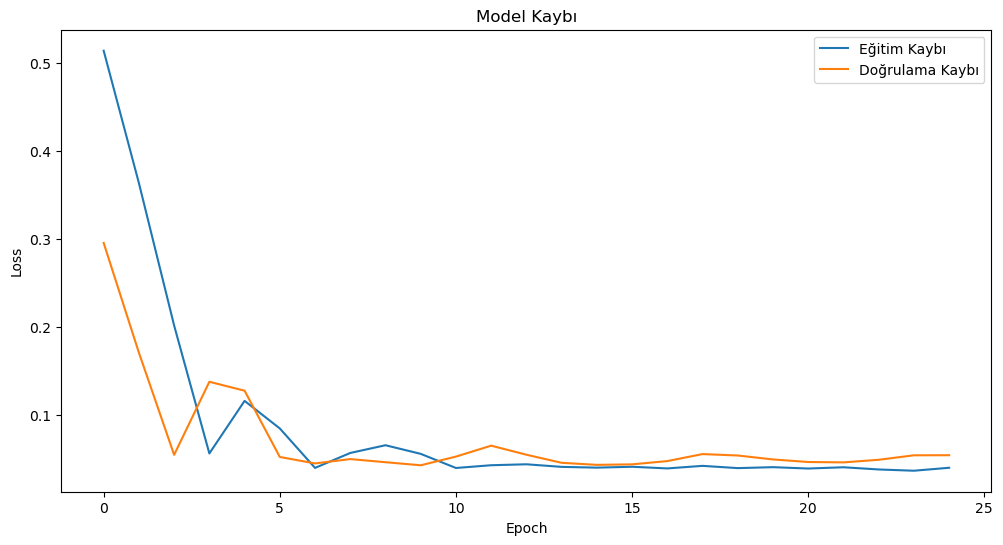

In [ ]:
# Eğitim ve doğrulama kaybını görselleştirelim
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Test verisi ile tahmin yapalım
y_pred = model.predict(X_test)

# Gerçek ve tahmin edilen verileri orijinal ölçeğe geri çevirelim
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# 2022'den 2030'a kadar tahmin yapalım
last_known_value = gdp_growth_scaled[-time_step:]  # Son 5 yıl
forecast_years = 2030 - 2022
forecasted_values = []

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


In [12]:
# İlk tahmin 2022'den başlayacak şekilde ayarlama
for i in range(forecast_years):
    prediction = model.predict(last_known_value.reshape(1, time_step, 1))
    forecasted_values.append(prediction[0, 0])
    last_known_value = np.append(last_known_value[1:], prediction, axis=0)  # Yeni tahminle birleştirelim

# Forecasted values'ı geri ölçekleyelim
forecasted_values_rescaled = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1))

# 2022 değeri dahil etmek için forecasted_values_rescaled dizisini düzenleyelim
forecasted_values_rescaled = np.insert(forecasted_values_rescaled, 0, scaler.inverse_transform(last_known_value[0].reshape(1, -1)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


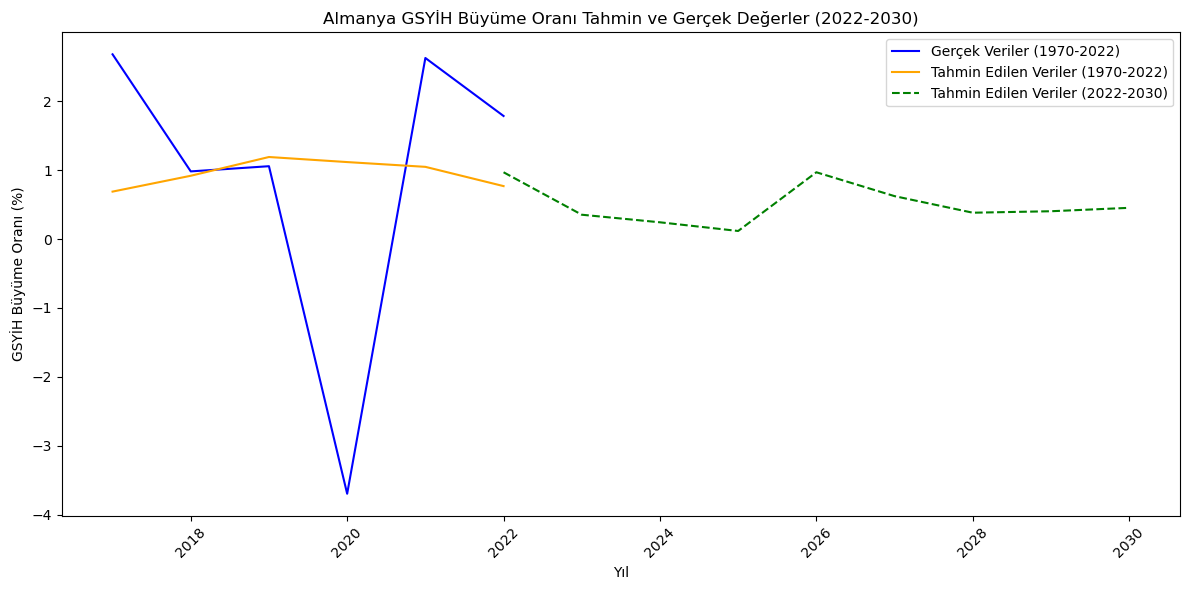

In [13]:
# Gerçek ve tahmin edilen verilerle birlikte grafiği çizelim
plt.figure(figsize=(12, 6))

# Gerçek veriler
plt.plot(germany_data_filled.index[train_size + time_step:], y_test_rescaled, label="Gerçek Veriler (1970-2022)", color='blue')

# Tahmin edilen veriler
plt.plot(germany_data_filled.index[train_size + time_step:], y_pred_rescaled, label="Tahmin Edilen Veriler (1970-2022)", color='orange')

# 2022'den 2030'a kadar tahmin edilen veriler
future_years = np.arange(2022, 2031)  # Başlangıç yılı 2022 olacak
plt.plot(future_years, forecasted_values_rescaled, label="Tahmin Edilen Veriler (2022-2030)", color='green', linestyle='--')

# Grafik detayları
plt.xlabel('Yıl')
plt.ylabel('GSYİH Büyüme Oranı (%)')
plt.title('Almanya GSYİH Büyüme Oranı Tahmin ve Gerçek Değerler (2022-2030)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [14]:


# RMSE hesaplayalım
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 2.2616169807447104


In [15]:


# MAE hesaplayalım
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 1.599924078041443


In [16]:


# MAPE hesaplayalım
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Mean Absolute Percentage Error (MAPE): 0.5679135709566939


In [17]:


# Modelin doğruluk oranını hesaplayalım
accuracy = (1 - mape) * 100
print(f"Doğruluk Oranı: {accuracy:.2f}%")

Doğruluk Oranı: 43.21%


In [18]:


# Bazı tahminleri yazdıralım
print("\nTahminler ve Gerçek Değerler:")
for i in range(min(10, len(y_test_rescaled))):  # Ensure we don't go out of bounds
    print(f"Yıl: {germany_data_filled.index[train_size + time_step + i]}, Gerçek: {y_test_rescaled[i][0]:.2f}, Tahmin: {y_pred_rescaled[i][0]:.2f}")



Tahminler ve Gerçek Değerler:
Yıl: 2017, Gerçek: 2.68, Tahmin: 0.69
Yıl: 2018, Gerçek: 0.98, Tahmin: 0.92
Yıl: 2019, Gerçek: 1.06, Tahmin: 1.19
Yıl: 2020, Gerçek: -3.70, Tahmin: 1.12
Yıl: 2021, Gerçek: 2.63, Tahmin: 1.05
Yıl: 2022, Gerçek: 1.79, Tahmin: 0.77
